In [1]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [2]:
%cd /gdrive/My Drive/AN2DL/leaves-classifier/

/gdrive/My Drive/AN2DL/leaves-classifier


In [ ]:
# Prepare data
!unzip dataset.zip
!find ./training/ -type d -print -exec sh -c "ls {} | wc -l | head -n1" \;

In [ ]:
!pip install split-folders

Data splitting

In [ ]:
import splitfolders

splitfolders.fixed('training', output="output_os", seed=4567, fixed=(50,50), oversample=True)

### Import libraries

In [4]:
import tensorflow as tf
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns

tfk = tf.keras
tfkl = tf.keras.layers

print(tf.__version__)

2.7.0


### Set seed for reproducibility

In [5]:
# Random seed for reproducibility
seed = 0xdeadbeef

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Dataset info

## Leaves

Classes: `['Apple','Blueberry','Cherry','Corn','Grape','Orange','Peach','Pepper','Potato','Raspberry','Soybean','Squash','Strawberry','Tomato']`

In [6]:
# Dataset folders 
dataset_dir = 'output_os'
training_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'val')
test_dir = os.path.join(dataset_dir, 'test')
model_dir = 'models'

In [7]:
# Plot example images from dataset
labels = ['Apple','Blueberry','Cherry','Corn','Grape','Orange','Peach','Pepper','Potato','Raspberry','Soybean','Squash','Strawberry','Tomato']

In [8]:
# Images are divided into folders, one for each class. 
# If the images are organized in such a way, we can exploit the 
# ImageDataGenerator to read them from disk.
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def simple_gen():
    return ImageDataGenerator(
            dtype=tf.float32,
        )

gen = simple_gen()

input_size = (256, 256)
input_shape = (256, 256, 3)
batch_size = 8

train_gen = gen.flow_from_directory(
    directory=training_dir,
    target_size=input_size,
    color_mode="rgb",
    classes=None,
    batch_size=batch_size,
    shuffle=True,
)

val_gen = gen.flow_from_directory(
    directory=validation_dir,
    target_size=input_size,
    color_mode="rgb",
    classes=None,
    batch_size=batch_size,
    shuffle=True,
    seed=seed
)

AUTOTUNE = tf.data.AUTOTUNE

augment_image = tf.keras.Sequential([
    tfkl.RandomFlip("horizontal_and_vertical"),
    tfkl.RandomContrast(0.123),
    tfkl.RandomZoom(0.2, 0.2, fill_mode="constant"),
    tfkl.RandomRotation(0.2, fill_mode="constant"),
    tfkl.RandomTranslation(0.2, 0.2, fill_mode="constant"),
])


train_ds = tf.data.Dataset.from_generator(
    lambda: train_gen,
    output_signature=(
         tf.TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32),
         tf.TensorSpec(shape=(None, len(labels)), dtype=tf.float32))
)
train_ds = train_ds.shuffle(256 // batch_size, reshuffle_each_iteration=True)
train_ds = train_ds.repeat()
train_ds = train_ds.map(
    lambda x, y: (augment_image(x, training=True), y),
    num_parallel_calls=AUTOTUNE,
    deterministic=False
)
train_ds = train_ds.prefetch(buffer_size=64)

val_ds = tf.data.Dataset.from_generator(
    lambda: val_gen,
    output_signature=(
         tf.TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32),
         tf.TensorSpec(shape=(None, len(labels)), dtype=tf.float32))
)
val_ds = val_ds.repeat().prefetch(buffer_size=4)

Found 50392 images belonging to 14 classes.
Found 700 images belonging to 14 classes.


In [9]:
print("Assigned labels")
print(train_gen.class_indices)
print("Target classes")
print(train_gen.classes)

Assigned labels
{'Apple': 0, 'Blueberry': 1, 'Cherry': 2, 'Corn': 3, 'Grape': 4, 'Orange': 5, 'Peach': 6, 'Pepper': 7, 'Potato': 8, 'Raspberry': 9, 'Soybean': 10, 'Squash': 11, 'Strawberry': 12, 'Tomato': 13}
Target classes
[ 0  0  0 ... 13 13 13]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(Input) image shape: (8, 256, 256, 3)
Target shape: (8, 14)
[107.82473 133.33157 101.37911]
Categorical label: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Label: 0
Class name: Apple


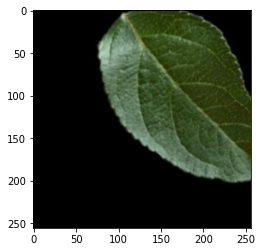

In [10]:
def get_next_batch(generator):
  image, target = next(generator)

  print("(Input) image shape:", image.shape)
  print("Target shape:",target.shape)

  # Visualize only the first sample
  image = image[0]
  target = target[0]
  target_idx = np.argmax(target)
  print(image[128, 128, :])
  print("Categorical label:", target)
  print("Label:", target_idx)
  print("Class name:", labels[target_idx])
  fig = plt.figure(figsize=(6, 4))
  plt.imshow(image / 255)

  return image, target
  
  # Get a sample from dataset and show info
_ = get_next_batch(train_ds.as_numpy_iterator())

### CNN model

In [11]:
def build_model(input_shape):
    inputs = tfk.Input(shape=input_shape)   
    x = tf.keras.applications.densenet.preprocess_input(inputs)
    supernet = tfk.applications.DenseNet201(
        include_top=False,
        weights="imagenet",
        input_shape=(256, 256, 3)
    )

    for l in supernet.layers[:]:
        l.trainable = False
        
    outputs = tfk.Sequential([
        supernet,
        tfkl.GlobalAveragePooling2D(),
        
        tfkl.Dense(
            96, 
            activation='relu'),
        tfkl.Dropout(0.3),
        
        tfkl.Dense(
            64, 
            activation='relu'),
        tfkl.Dropout(0.3),

        tfkl.Dense(
            32, 
            activation='relu'),
        tfkl.Dropout(0.3),

        tfkl.Dense(
            len(labels), 
            activation='softmax',)
    ])(x)
    
    # Connect input and output through the Model class
    model = tfk.Model(inputs=inputs, outputs=outputs)

    # Return the model
    return model

In [12]:
# Utility function to create folders and callbacks for training
from datetime import datetime

def create_folders_and_callbacks(model_name):

  exps_dir = os.path.join('experiments')
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = []

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp'),
                                                     save_weights_only=True,
                                                     save_best_only=True)
  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
      
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                               profile_batch=0,
                                               histogram_freq=1)
  callbacks.append(tb_callback)

  # Early Stopping
  # --------------
  es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
  callbacks.append(es_callback)

  return callbacks

In [13]:
model_name = 'DenseNet201-GAP-D96-D64-D32'
model_path = os.path.join(model_dir, model_name)
weights_path = os.path.join(model_dir, "weights_dir", model_name, model_name)

tfk.backend.clear_session()

model = build_model(input_shape)
# model = tfk.models.load_model(model_path)
#model.load_weights("./experiments/DenseNet201-GAP-D96-D64-D32_Nov25_15-47-02/ckpts/cp")

callbacks = create_folders_and_callbacks(model_name=model_name)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 256, 256, 3)      0         
 )                                                               
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 256, 256, 3)      0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 256, 256, 3)      0         
 da)                                                             
                                                                 
 sequential (Sequential)     (None, 14)                18515150  
                                                                 
Total params: 18,515,150
Trainable params: 193,166
Non-traina

In [13]:
model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(epsilon=0.01), metrics='accuracy')

epochs = 40


# Train the model
history = model.fit(
    x = train_ds,
    steps_per_epoch=500,
    epochs = epochs,
    validation_data = val_ds,
    validation_steps = 50,
    callbacks = callbacks,
).history

Epoch 1/40
500/500 [==============================] - 702s 1s/step - loss: 0.4740 - accuracy: 0.8565 - val_loss: 0.8043 - val_accuracy: 0.7275
Epoch 2/40
500/500 [==============================] - 555s 1s/step - loss: 0.4025 - accuracy: 0.8832 - val_loss: 0.5538 - val_accuracy: 0.8182
Epoch 3/40
500/500 [==============================] - 537s 1s/step - loss: 0.4218 - accuracy: 0.8777 - val_loss: 0.7609 - val_accuracy: 0.7500
Epoch 4/40
500/500 [==============================] - 573s 1s/step - loss: 0.4238 - accuracy: 0.8805 - val_loss: 0.5654 - val_accuracy: 0.7955
Epoch 5/40
500/500 [==============================] - 592s 1s/step - loss: 0.3941 - accuracy: 0.8892 - val_loss: 0.6219 - val_accuracy: 0.7825
Epoch 6/40
500/500 [==============================] - 563s 1s/step - loss: 0.3907 - accuracy: 0.8920 - val_loss: 0.6543 - val_accuracy: 0.7825
Epoch 7/40
500/500 [==============================] - 548s 1s/step - loss: 0.3840 - accuracy: 0.8895 - val_loss: 0.5318 - val_accuracy: 0.8283

In [14]:
supernet = model.layers[4].layers[0]

print(supernet.name)

train_thresh = 500
supernet.trainable = True

for l in supernet.layers[:train_thresh]:
    l.trainable = False
for l in supernet.layers[train_thresh:]:
    if "conv" not in l.name:
        l.trainable = False

# supernet.summary()


densenet201


In [ ]:
model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(0.00005, epsilon=0.01), metrics='accuracy')

epochs = 50

# Train the model
history = model.fit(
    x = train_ds,
    steps_per_epoch=500,
    epochs = epochs,
    validation_data = val_ds,
    validation_steps = len(val_gen),
    callbacks = callbacks,
).history

In [ ]:
# Save best epoch model
model.save_weights(weights_path)
model.save(model_path)

In [ ]:
test_batch_size = 4
test_data_gen = simple_gen()
test_gen = test_data_gen.flow_from_directory(
    directory=test_dir,
    target_size=input_size,
    color_mode="rgb",
    classes=None,
    batch_size=test_batch_size,
    shuffle=False,
    seed=seed
)
model.compile(loss=tfk.losses.CategoricalCrossentropy(), metrics='accuracy')
model.evaluate(test_gen)

In [ ]:
test_l = len(test_gen) * test_batch_size
print(test_l)
predictions = np.zeros((test_l,))
y_test = np.zeros((test_l,))

s = 0
for X, y in test_gen:
    y_idx = np.argmax(y, axis=-1)
    p_idx = np.argmax(model.predict(X), axis=-1)
    l = len(y_idx)
    if s + l >= test_l:
        break
    y_test[s:s + l] = y_idx
    predictions[s:s + l] = p_idx
    s += l

predictions = predictions[:s]
y_test = y_test[:s]
predictions.shape

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, predictions)

# Compute the classification metrics
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=list(labels), yticklabels=list(labels))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

# Visualize the activations

In [ ]:
# Get sample batch
batch = next(test_gen)[0]

# Get first image
image = batch[0] # batch size = 8

fig = plt.figure(figsize=(6, 4))
plt.imshow(np.uint8(image))

In [ ]:
# Get the activations (the output of each ReLU layer)
# We can do it by creating a new Model (activation_model) with the same input as 
# the original model and all the ReLU activations as output
layers = [layer.output for layer in supernet.layers if isinstance(layer, tfk.layers.Conv2D)]

print(len(layers))
activation_model = tf.keras.Model(inputs=supernet.input, outputs=layers)

# Finally we get the output feature maps (for each layer) given the imput test image
fmaps = activation_model.predict(tf.expand_dims(image, 0))

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
%matplotlib inline
def display_activation(fmaps, depth=0, first_n=-1): 
    # fmaps: list of all the feature maps for each layer
    # depth: the layer we want to visualize (an int in [0, network depth))
    # first_n: default '-1' means 'all activations'. Number of activations to be visualized. Note that for deep layers it could be a large number.

    fmaps = fmaps[depth] # get feature maps at the desired depth
    if first_n > 0:
      fmaps = fmaps[0, :, :, :first_n] 
    fmaps = tf.image.resize(fmaps, size=[128, 128]) # resize for visualization

    # Distribute on a grid for plotting
    col_size = 8
    row_size = fmaps.shape[-1] // 8
    fmap_channel=0
    fig = plt.figure(figsize=(30, 30))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                    nrows_ncols=(row_size, col_size),  
                    axes_pad=0.1,  # pad between axes in inch.
                    )
    for row in range(0,row_size):
        for col in range(0,col_size):
            grid[fmap_channel].imshow(fmaps[0, :, :, fmap_channel], cmap='gray', aspect='auto')
            fmap_channel += 1
    plt.show()

In [ ]:
for i in range(0, 4, 2):
    print(i)
    display_activation(fmaps=fmaps, depth=i, first_n=-1)